## Libs

In [1]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')
sns.set_style('darkgrid') # darkgrid, darkgrid

## Funcs

In [3]:
def make_df(file_path):
    df = pd.read_csv(file_path, index_col='date', sep=';')
    df['date'] = pd.to_datetime(df.index)
    df.set_index('date', inplace=True)
    df.head()
    return df


def replace_spaces_in_strings(df):
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.replace(' ', '').astype('float64')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('float64')


def scale_series(series, scale=1):
    scaled = series * (1 / scale)
    return scaled


def scale_df(df, thsnds_col=None, mlns_col=None):
    if thsnds_col is not None:
        for col in df[thsnds_col]:
            df[col] = df[col].apply(scale_series, scale=1_000)
    if mlns_col is not None:
        for col in df[mlns_col]:
            df[col] = df[col].apply(scale_series, scale=1_000_000)

def print_data_info(df):
    # Data Summary
    print('Data Shape:', df.shape)
    print('\nData Types:')
    print(df.dtypes)

    # Missing Values Check
    print('\nMissing Values:')
    print(df.isnull().sum())

    # info about dataframe 
    print(df.info())

    # Statistical Summary
    print('\nStatistical Summary:')
    print(df.describe())

    # Adjusting the layout to accommodate all numerical columns
    num_columns = df.select_dtypes(include=['number']).shape[1]

    # Print correlations
    print(df.corr())
    print(sns.heatmap(df.corr()))


    rows = num_columns // 3 + (num_columns % 3 > 0)

    # Histograms for each numerical variable
    df.hist(bins=15, figsize=(15, rows * 5), layout=(rows, 3))
    plt.tight_layout()
    plt.show()


    # Box plots for each numerical variable
    df.plot(kind='box', subplots=True, layout=(rows, 3), figsize=(15, rows * 5), sharex=False, sharey=False)
    plt.tight_layout()
    plt.show()



## Import data

In [5]:
file_path = '../data/data_demo.csv'

df = make_df(file_path)

df.head(3)

,old_sales,sales,price,queries,visits_cost,visits_count,banner_quant,banner_cost,banner_cost_new,context_quant,...,tvr_park,tvr_theatre,tvr_wave,tv_cost,tvr_ambro,tvr_acc,tvr_brom,tvr_doc,tvr_kodel,tvr_lazol
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102 530,95 353,143,645 354,1 508 543,2 193,0,0,0,9 221,...,0,0,0,0,205,397,253,121,249,331
2019-01-07,133 632,124 278,143,615 454,1 508 543,2 193,0,0,0,9 221,...,281,0,0,12 490 514,270,433,202,204,248,319
2019-01-14,135 094,125 637,143,573 170,2 724 790,3 960,0,0,0,9 221,...,222,0,0,9 835 858,228,235,136,206,270,284


## Preprocessing

In [116]:
replace_spaces_in_strings(df)


df['tvr'] = df[[
    'tvr_park', 
    'tvr_wave', 
    'tvr_theatre'
]].sum(axis=1)


scale_df(df,
         thsnds_col=[
            'old_sales',
            'sales',
            'queries',
            'visits_cost',
            'banner_cost',
            'banner_cost_new',
            'olv_cost',
            'olv_cost_new',
            'social_cost',
            'social_cost_new',
            'tv_cost',
         ]
)
# df.describe()[thsnds_col].loc['mean', :]




old_sales           164.331788
sales               152.828600
queries             636.691718
visits_cost        2482.344706
banner_cost         124.703259
banner_cost_new      94.933276
olv_cost            376.082459
olv_cost_new        286.241265
social_cost         155.743371
social_cost_new     118.905135
tv_cost            5138.300247
tvr                 121.976471
Name: mean, dtype: float64

Data Shape: (170, 29)

Data Types:
old_sales           float64
sales               float64
price               float64
queries             float64
visits_cost         float64
visits_count        float64
banner_quant        float64
banner_cost         float64
banner_cost_new     float64
context_quant       float64
context_cost        float64
context_cost_new    float64
olv_quant           float64
olv_cost            float64
olv_cost_new        float64
social_quant        float64
social_cost         float64
social_cost_new     float64
tvr_park            float64
tvr_theatre         float64
tvr_wave            float64
tv_cost             float64
tvr_ambro           float64
tvr_acc             float64
tvr_brom            float64
tvr_doc             float64
tvr_kodel           float64
tvr_lazol           float64
tvr                 float64
dtype: object

Missing Values:
old_sales           0
sales               0
price               0
queries             0
visits_cost         0
visits_count

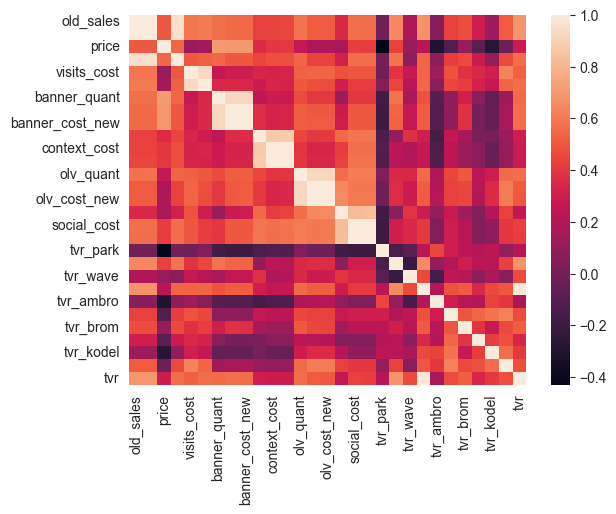

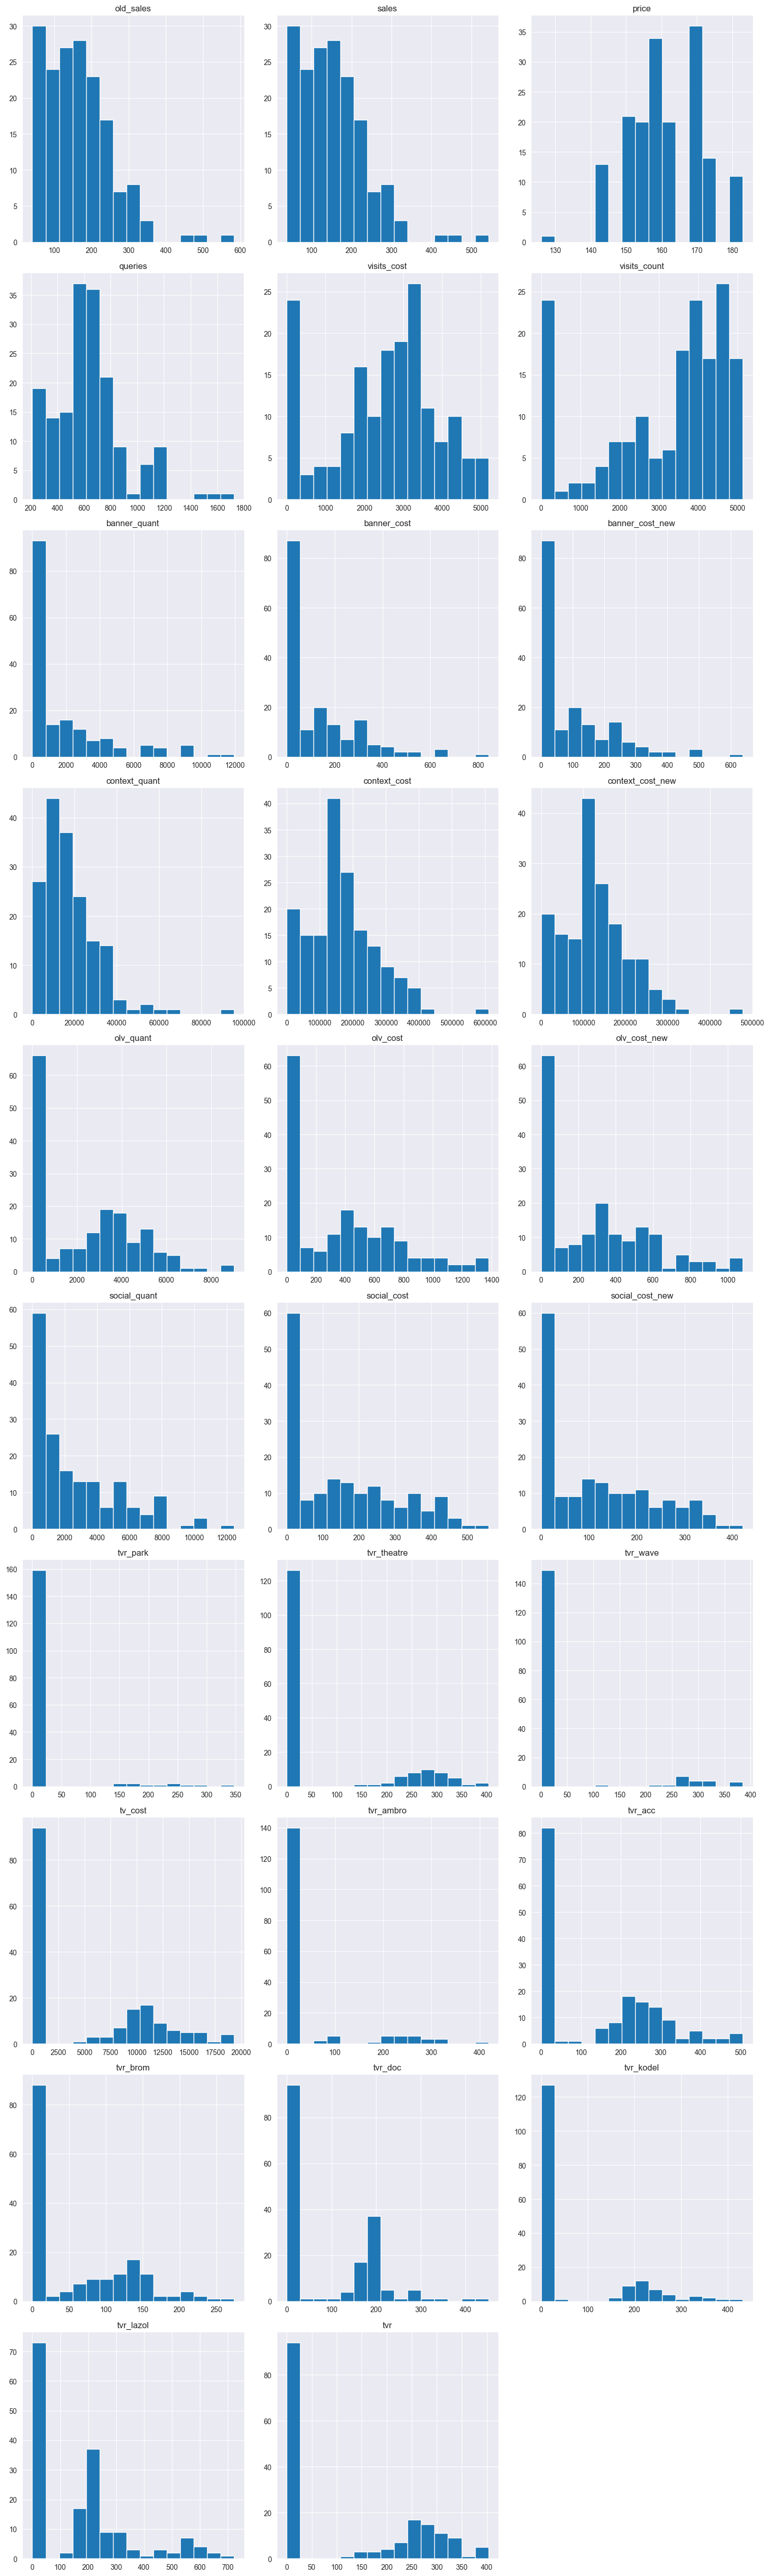

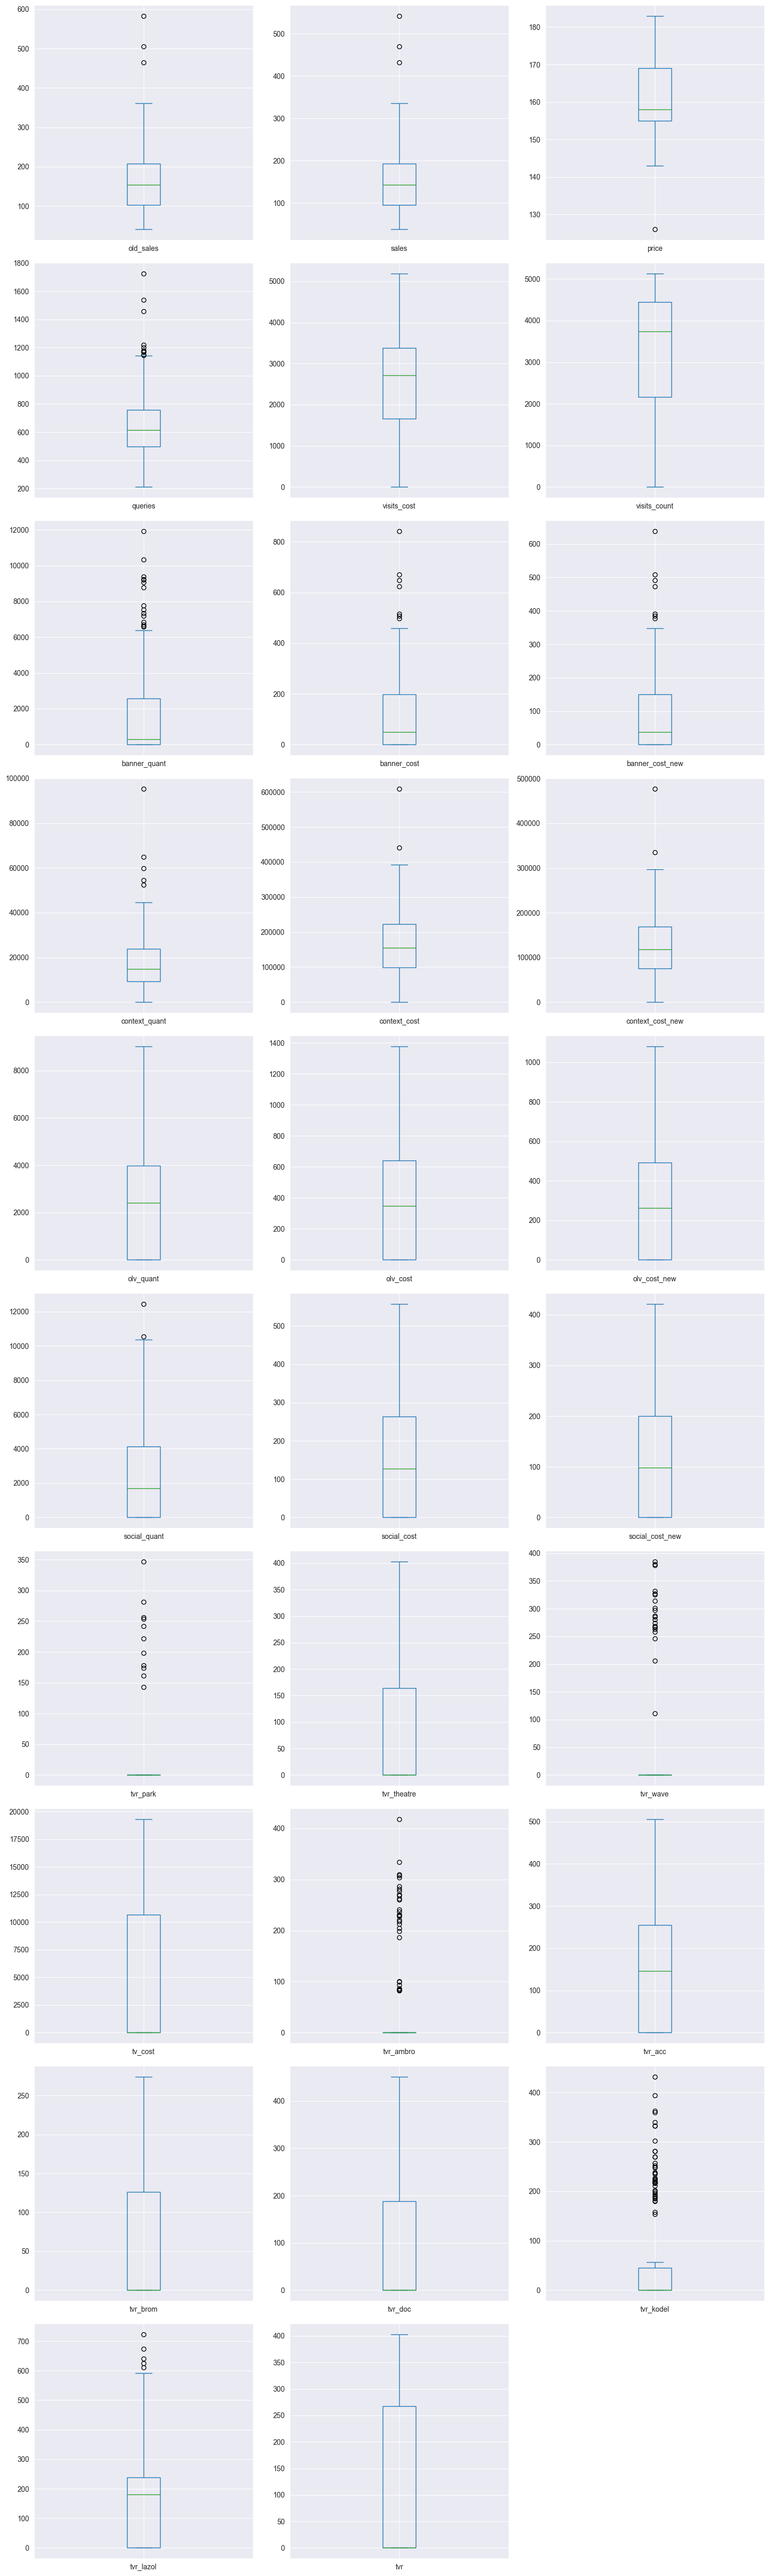

In [117]:
print_data_info(df)

## Compare two models

In [119]:
y = df['sales']

X1 = df[['tv_cost', 'olv_cost']]
X1 = sm.add_constant(X1)

X2 = df[['tvr', 'olv_cost']]
X2 = sm.add_constant(X2)

X3 = df[['tv_cost', 'olv_cost', 'visits_cost']]
X3 = sm.add_constant(X3)


models = [
    sm.OLS(y, X1).fit(),
    sm.OLS(y, X2).fit(),
    sm.OLS(y, X3).fit()
]

# Combine summaries into a single dataframe
summary_table = summary_col(models, float_format='%0.4f', stars=True)

# Convert the summary table to a pandas dataframe
summary_df = pd.DataFrame(summary_table.tables[0])

# Print or display the consolidated summary dataframe
summary_df

,sales I,sales II,sales III
R-squared,0.4957,0.5090,0.5430
R-squared Adj.,0.4897,0.5031,0.5348
const,95.8094***,93.9482***,70.0301***
,(6.6499),(6.6032),(8.8883)
olv_cost,0.0457***,0.0458***,0.0245*
,(0.0142),(0.0139),(0.0145)
tv_cost,0.0078***,,0.0064***
,(0.0009),,(0.0009)
tvr,,0.3415***,
,,(0.0367),


## Seasonality

In [120]:
import statsmodels.api as sm

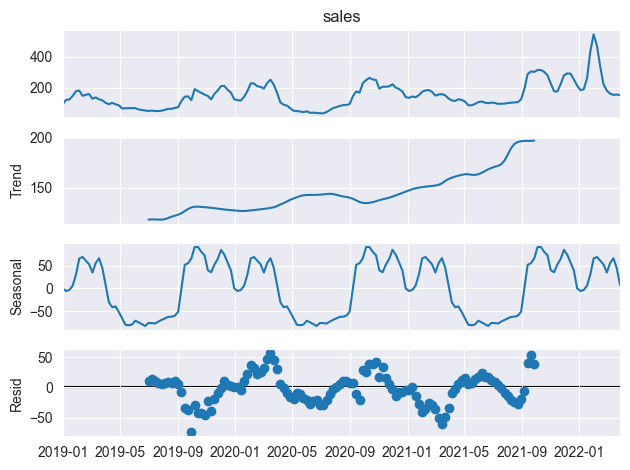

In [122]:
result_add = sm.tsa.seasonal_decompose(y, model='additive')
result_add.plot()
plt.show()

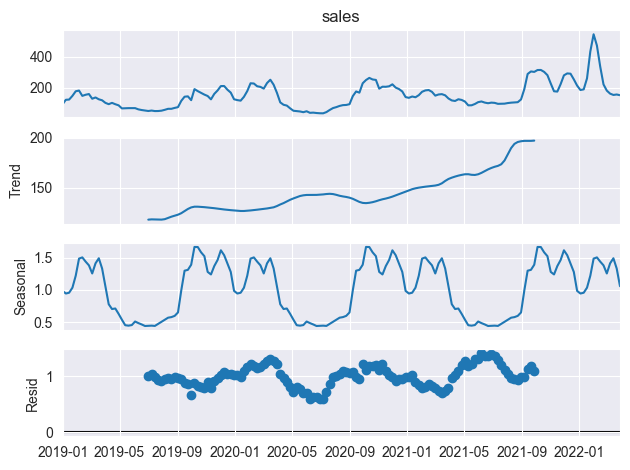

In [125]:
result_mul = sm.tsa.seasonal_decompose(y, model='multiplicative')
result_mul.plot()
plt.show()

In [147]:
from statsmodels.tsa.seasonal import STL

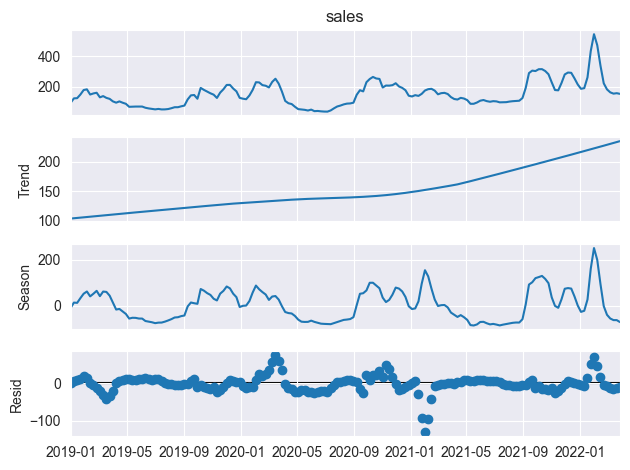

In [153]:
res_stl = STL(y).fit()
res_stl.plot()
plt.show()

In [176]:
df_timeseries = pd.DataFrame(y)
df_timeseries['res_stl_resid'] = res_stl.resid
df_timeseries['res_stl_trend'] = res_stl.trend
df_timeseries['res_stl_seasonal'] = res_stl.seasonal


df_timeseries.head()

,sales,res_stl_resid,res_stl_trend,res_stl_seasonal
date,,,,
2018-12-31,95.353,0.703942,103.436534,-8.787476
2019-01-07,124.278,5.943917,103.966984,14.367099
2019-01-14,125.637,7.914803,104.497032,13.225165
2019-01-21,149.294,10.610880,105.026635,33.656485
2019-01-28,178.678,20.341403,105.555729,52.780868


In [177]:
df_timeseries.describe()


,sales,res_stl_resid,res_stl_trend,res_stl_seasonal
count,170.000000,170.000000,170.000000,170.000000
mean,152.828600,-1.074885,150.486288,3.417198
std,82.615768,23.465247,35.130525,66.695430
min,37.889000,-130.989482,103.436534,-84.798406
25%,95.954500,-11.571157,125.044455,-59.247843
50%,143.622500,-0.906240,138.898356,-0.053312
75%,192.589750,8.147789,172.069390,52.879387
max,542.444000,75.919800,234.689269,250.579175


In [179]:
df['trend_stl'] = res_stl.trend
df['seasonality_stl'] = res_stl.seasonal

In [183]:
y = df['sales']

X1 = df[['tvr', 'olv_cost']]
X1 = sm.add_constant(X2)

X2 = df[[
    'tvr', 
    'olv_cost', 
    'trend_stl', 
    'seasonality_stl'
]]
X2 = sm.add_constant(X2)

X3 = df[[
    'tvr', 
    'olv_cost', 
    'seasonality_stl'
]]
X3 = sm.add_constant(X3)



models = [
    sm.OLS(y, X1).fit(),
    sm.OLS(y, X2).fit(), 
    sm.OLS(y, X3).fit(),

]

summary_table = summary_col(models, float_format='%0.4f', stars=True)
summary_df = pd.DataFrame(summary_table.tables[0])
summary_df

,sales I,sales II,sales III
R-squared,0.9200,0.9200,0.7619
R-squared Adj.,0.9180,0.9180,0.7575
const,-1.5632,-1.5632,135.1825***
,(8.2352),(8.2352),(5.5607)
olv_cost,0.0021,0.0021,0.0016
,(0.0060),(0.0060),(0.0103)
seasonality_stl,0.9748***,0.9748***,0.8959***
,(0.0395),(0.0395),(0.0675)
trend_stl,0.9839***,0.9839***,
,(0.0545),(0.0545),


For predicting in the future:




